In [32]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Water', 'Price_2016': 2.50, 'Price_2024': 3.50}
]

In [33]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Water: 40.00% Inflation


In [34]:
!pip install fredapi

In [ ]:
from dotenv import load_dotenv
from fredapi import Fred
import os

load_dotenv()
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key)

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
streaming = fred.get_series('CUSR0000SERA02')
food_away = fred.get_series('CUSR0000SEFV')

In [36]:
official_cpi_index = (official_cpi / official_cpi.loc['2016-01-01']) * 100
tuition_index = (tuition / tuition.loc['2016-01-01']) * 100
rent_index = (rent / rent.loc['2016-01-01']) * 100
streaming_index = (streaming / streaming.loc['2016-01-01']) * 100
food_away_index = (food_away / food_away.loc['2016-01-01']) * 100

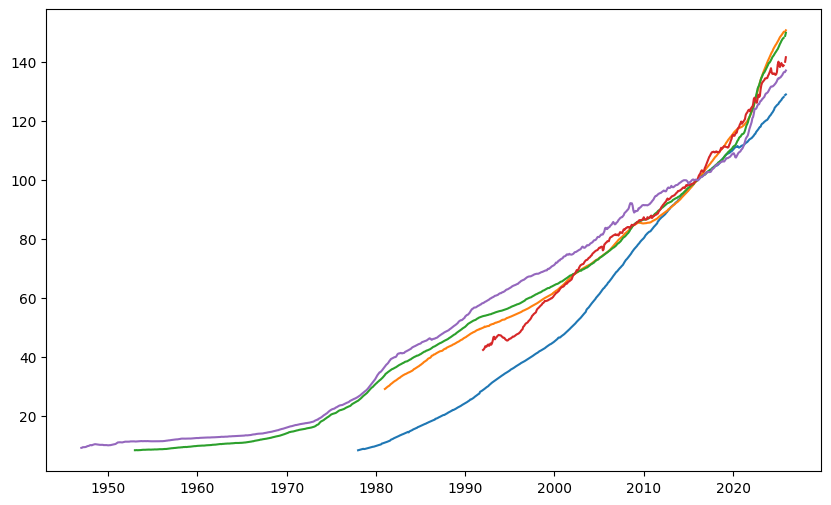

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(tuition_index, label='Tuition')
plt.plot(rent_index, label='Rent')
plt.plot(food_away_index, label='Burritos')
plt.plot(streaming_index, label='Streaming')
plt.plot(official_cpi_index, label='Official CPI')

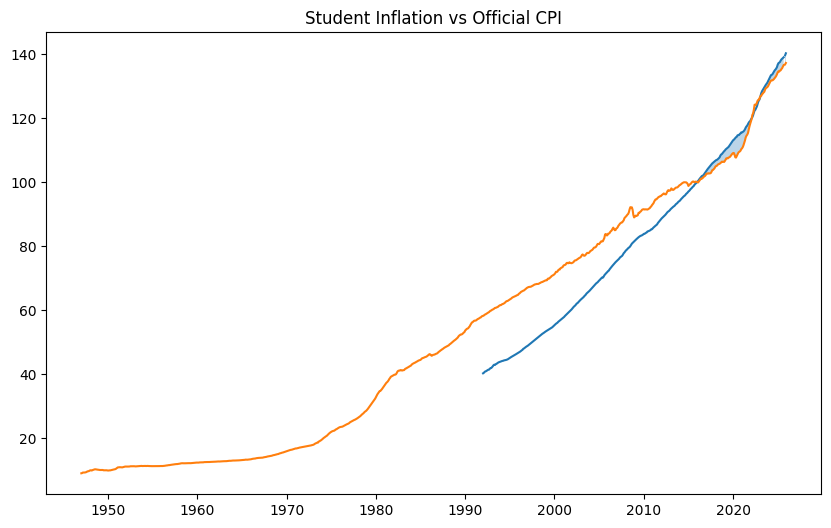

In [ ]:
import pandas as pd

weights = {
    'Tuition': 0.4,
    'Rent': 0.3,
    'Streaming': 0.2,
    'FoodAway': 0.1
}

df = pd.DataFrame({
    'CPI': official_cpi_index,
    'Tuition': tuition_index,
    'Rent': rent_index,
    'Streaming': streaming_index,
    'FoodAway': food_away_index
})

df['Student_SPI'] = (
    weights['Tuition'] * df['Tuition'] +
    weights['Rent'] * df['Rent'] +
    weights['Streaming'] * df['Streaming'] +
    weights['FoodAway'] * df['FoodAway']
)


plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Student_SPI'])
plt.plot(df.index, df['CPI'])
plt.title('Student Inflation vs Official CPI')

plt.fill_between(
    df.index,
    df['Student_SPI'],
    df['CPI'],
    where=(df['Student_SPI'] > df['CPI']),
    alpha=0.3
)

Text(0.5, 1.0, 'RAW (Non-Normalized) Data')

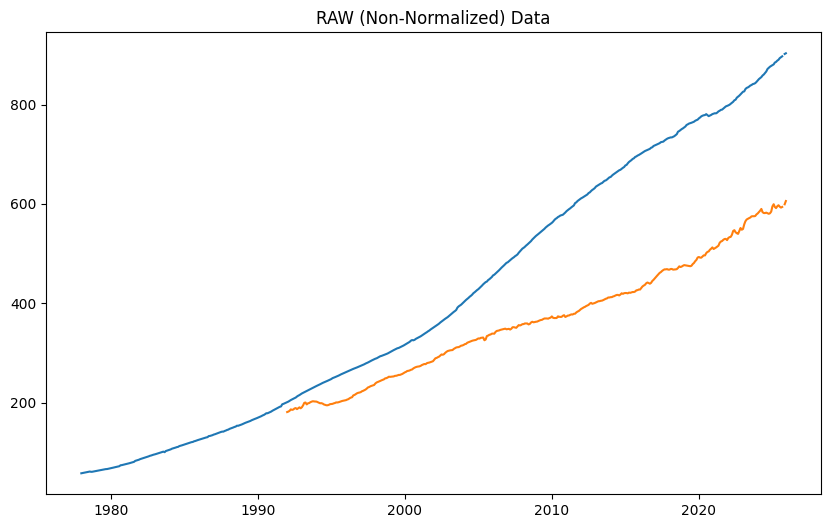

In [39]:
plt.figure(figsize=(10, 6))

plt.plot(tuition)
plt.plot(streaming)
plt.title('RAW (Non-Normalized) Data')

Comparing raw indicies with different base years is a "data crime" because it shows statistics based on the base year, rather than the actual differences in inflation. It causes the series to appear differently and mislead people as well.

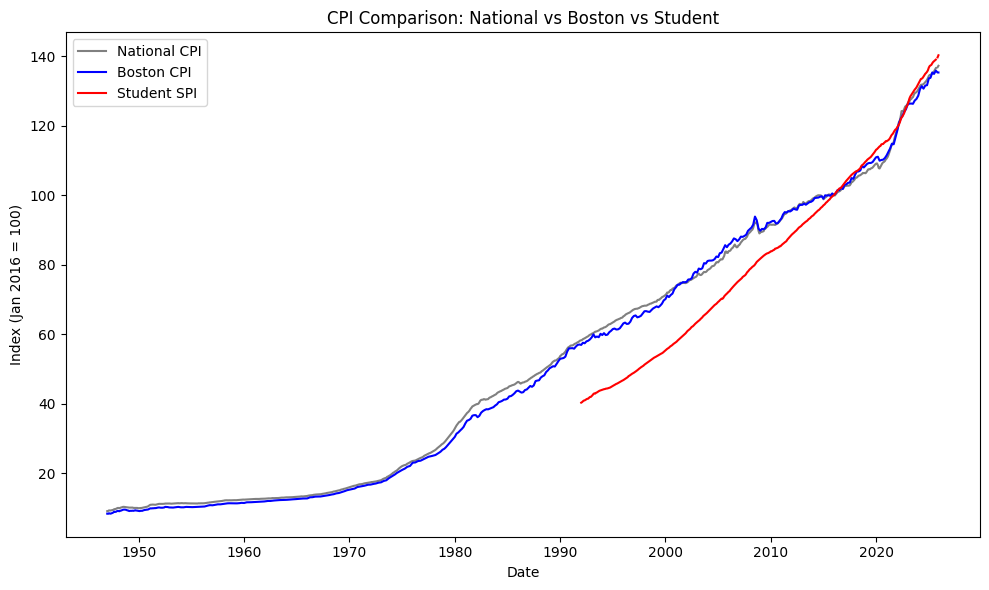

In [41]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Initialize FRED (assumes FRED_API_KEY is set in environment)
fred = Fred()

# FRED series code for CPI-U: Boston-Cambridge-Newton, MA-NH (All Items)
BOSTON_CPI_CODE = "CUURA103SA0"

# Fetch Boston CPI
boston_cpi = fred.get_series(BOSTON_CPI_CODE)
boston_cpi.index = pd.to_datetime(boston_cpi.index)

# Reindex to match df index and handle missing values
boston_cpi = boston_cpi.reindex(df.index)
boston_cpi = boston_cpi.interpolate(method="time")

# Rebase Boston CPI so Jan 2016 = 100
base_date = pd.Timestamp("2016-01-01")
boston_cpi = (boston_cpi / boston_cpi.loc[base_date]) * 100

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["CPI"], color="grey", label="National CPI")
plt.plot(df.index, boston_cpi, color="blue", label="Boston CPI")
plt.plot(df.index, df["Student_SPI"], color="red", label="Student SPI")

plt.legend()
plt.title("CPI Comparison: National vs Boston vs Student")
plt.xlabel("Date")
plt.ylabel("Index (Jan 2016 = 100)")
plt.tight_layout()
plt.show()